# Датасет [WIDER FACES](http://shuoyang1213.me/WIDERFACE/)


In [1]:
from scipy import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
path_mat = 'WiderFaces/wider_face_train.mat'
path_images = 'C:/Users/Fedor/Documents/Projects/BelkaFaces/WiredFaces/WIDER_train/All'

In [3]:
mat = io.loadmat(path_mat)

### Список всех файлов

In [4]:
all_files = mat['file_list']

### Список всех координат лиц

In [5]:
all_boxes = mat['face_bbx_list']

## Пример изображений в датасете

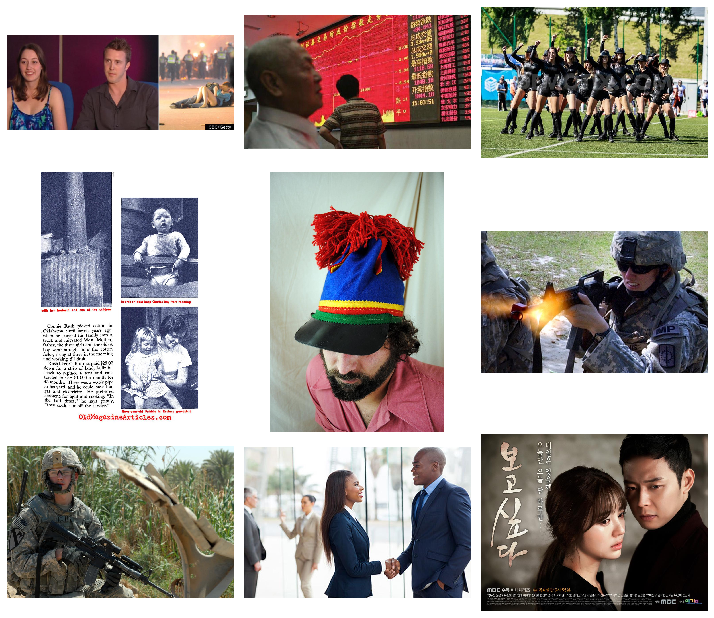

In [18]:
display_images(choose_random_images())

## Получим данные об изображениях в датасете

### Выберем рандомное изображение

In [325]:
random_image = choose_random_images(n=1)[0]
random_image

'40_Gymnastics_Gymnastics_40_578.jpg'

### Его номер в датасете 

In [326]:
folder, file = get_num_of_image(random_image)

Folder: 35 
File: 60


### Координаты лиц на изображении

In [327]:
boxes = get_boxes(folder, file)
boxes

array([[ 55, 214,  39,  38],
       [140, 251,  35,  40],
       [228, 274,  36,  40],
       [257, 237,  35,  38],
       [241, 192,  36,  42],
       [325, 278,  36,  42],
       [349, 222,  36,  38],
       [422, 281,  38,  43],
       [450, 232,  38,  45],
       [569, 221,  48,  48],
       [538, 285,  38,  48],
       [646, 290,  40,  45],
       [753, 153,  41,  48],
       [697, 222,  39,  49],
       [864, 166,  46,  54],
       [762, 297,  38,  43],
       [885, 310,  40,  48]])

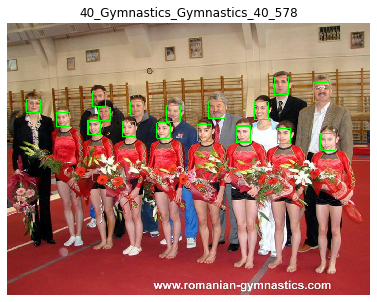

In [328]:
draw_rect(random_image, boxes)

## Easy (Scale) WIDER FACES

Датасет делится на три уровня сложности по размеру лиц на изображении: Легкий (больше 300 pixels), Средний (50-300 pixels), Сложный (10-50 pixels). Мы будем рассматривать легкую часть датасета (по рамзеру лиц), т.к. нам больше важен аспект расположения лица (угол, наклон) и аспект occlusion (макияж, маски, очки и т.д.). К тому же нет необходимости обнаруживать совсем маленькие лица на изображениях. 

In [15]:
easy_names = ['Gymnastics', 'Handshaking', 'Waiter', 'Conference',
                'Worker', 'Parachutist', 'Coach', 'Meeting',
                'Aerobics', 'Boat', 'Dancing', 'Swimming', 
                'Family', 'Balloonist', 'Dresses', 'Couple', 
                'Jockey', 'Tennis', 'Spa', 'Surgeons']


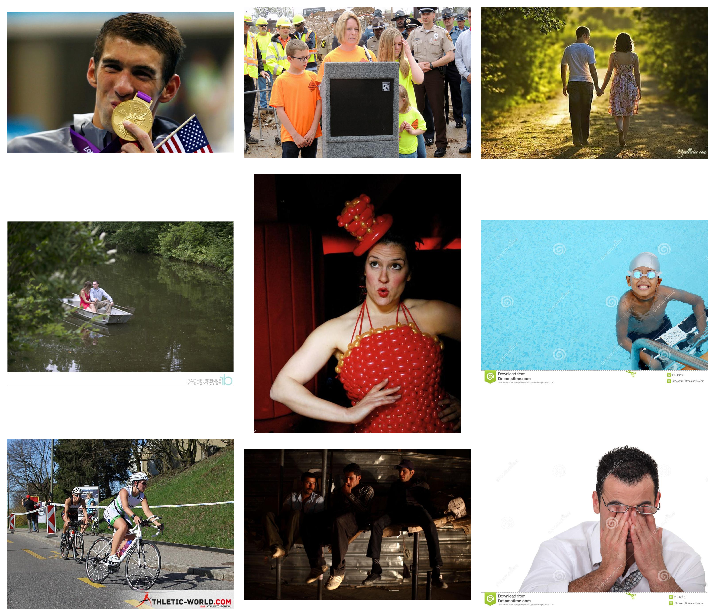

In [217]:
display_images(choose_random_images(easy=True))

## Helpers


In [7]:
def convert2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [8]:
def choose_random_images(easy=False, n=10):
    
    """
    Выбрать из датасета n картинок в случайном порядке
    easy=True -- выбрать из легкой части датасета  
    """
    
    images = []
    for _ in range(n):
        if(easy):
            easy_folders = get_easy_folders()
            folder = all_files[random.choice(easy_folders)]
        else:    
            folder = random.choice(all_files)
            
        name = random.choice(folder[0])[0][0]
        images.append(name + ".jpg")
    return images

In [9]:
def get_num_of_image(name):
    folder_num = -1 
    file_num = -1
    for folder in all_files:
        folder_num += 1
        file_num = -1
        for file_name in folder[0]:
            file_num += 1
            name_ = file_name[0][0]
            if (name_ + '.jpg' == name):
                # print("Folder: {0} \nFile: {1}".format(folder_num, file_num))
                return folder_num, file_num    

In [10]:
def get_boxes(folder, file):
    return all_boxes[folder][0][file][0]

In [11]:
def get_all_boxes(images):
    boxes = []
    for image in images:
        folder, file = get_num_of_image(image)
        boxes.append(get_boxes(folder, file))
    return boxes

In [12]:
def draw_rect(image, boxes):
    test_image = cv2.imread(path_images + '//' + image)
    img_copy = np.copy(test_image)
    
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_copy,(x, y), (x+w, y+h), (0, 255, 0), 2)
        
    fig,ax = plt.subplots(1)
    fig.set_size_inches(9, 5)
    ax.set_title(image.split('.')[0])
    ax.imshow(convert2RGB(img_copy))
    plt.axis('off')
    plt.show()

In [13]:
def display_images(images):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        test_image = cv2.imread(path_images + '//' + images[i])
        img_copy = np.copy(test_image)
        
        fig.add_subplot(rows, columns, i)
        plt.imshow(convert2RGB(img_copy))
        plt.axis('off')
        plt.tight_layout(True)
    plt.show()
    

In [16]:
def get_easy_folders(easy_names=easy_names):
    easy_folders = []
    for name in easy_names:
        for i in range(0, len(all_files)):
            if (name in all_files[i][0][0][0][0]):
                easy_folders.append(i)
    return easy_folders

# Тестирование решений

**Как будем тестировать?** 

1. Выбираем рандомные n изображений из датасета
2. Получаем координаты всех лиц на всех изображениях 
3. Получаем результаты работы методов на этих изображениях, т.е. получаем координаты лиц
4. Сравниваем полученные результаты с реальными координатами 
5. Считаем среднюю ошибку по координатам. Сортируем методы по возрастанию ошибки
   1. Если метод не дал координат лица (не обнаружил лицо), то добавляем n-m нулевых векторов, где n - количество лиц на изображении, m - количество обнаруженных лиц.

### N рандомных изображений

In [19]:
images = choose_random_images(easy=True, n=10)

### Координаты лиц

In [20]:
boxes = get_all_boxes(images)

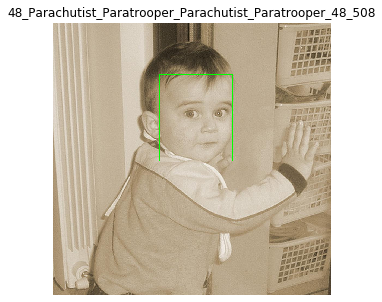

In [154]:
r = random.choice(range(0,10))
draw_rect(images[8], boxes[8])

### Точность метода
Для определения точности работы алгоритма будем использовать метрику IOU (Intersection over Union). Для каждого лица на изображении (ground-truth вектор) проверяем среди всех полученных векторов из метода параметр IOU. Если этот параметр $\geq0.5$, то лицо обнаружено верно, этот вектор обозначим как True Positive (TP). Если в конце у нас остались неподходящие векторы, то обозначаем как False Positive (FP). Если же лица вовсе не обнаружены, то обозначаем их как False Negative (FN). Из всевозможных метрик нам наиболее важен recall (recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм, т.е. показывает сколько лиц из всех лиц мы действительно нашли). $recall = \frac{TP}{TP + FN}$

In [156]:
def bb_intersection_over_union(ground_truth, predicted):
    
    boxA = [ground_truth[0], ground_truth[1], ground_truth[0] +
            ground_truth[2], ground_truth[1] + ground_truth[3]]
    boxB = [predicted[0], predicted[1], predicted[0] +
                 predicted[2], predicted[1] + predicted[3]]
    
    # (x, y) - координаты прямоугольника из пересечения
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # Площадь прямоугольника, образованного пересечением двух других
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # Общая площадь двух прямоугольников
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # intersection over union 
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [233]:
def mean_error(results, boxes=boxes):
    
    error = 0
    
    # results -- массив массивов координат лиц
    for i in range(0, len(boxes)):
        
        # Кол-во лиц на i картинке
        num_faces = len(boxes[i])
        
        # Дополняем нулевыми векторами,
        # Если лиц обнаружено меньше
        while(len(results[i]) < num_faces):
            results[i] = np.append(results[i], np.zeros(4)) 
        
        for j in range(0, num_faces):
            # Реальные координаты j лица на i картинке
            a = boxes[i][j]
            
            # Координаты j лица на i картинке из метода
            b = results[i][j]
        
            # Евклидова метрика (насколько близки вектора)
            dist = np.linalg.norm(a-b)  
            
            # Ошибка
            error += dist
            
    return error

## Каскады Хаара и LBP ([OpenCV](https://github.com/opencv/opencv))

### Каскады Хаара

In [46]:
haar_path = 'HaarCascades/'
haars = [haar_path + x for x in os.listdir(haar_path)]
haars

['HaarCascades/haarcascade_frontalface_alt.xml',
 'HaarCascades/haarcascade_frontalface_alt2.xml',
 'HaarCascades/haarcascade_frontalface_alt_tree.xml',
 'HaarCascades/haarcascade_frontalface_default.xml',
 'HaarCascades/haarcascade_profileface.xml']

#### Ошибки разных каскадов Хаара

In [47]:
haar_res = cascades_error(haars)
haar_res

NameError: name 'cascades_error' is not defined

#### Лучший результат

In [236]:
get_best_res(haar_res)

('haarcascade_frontalface_alt2', 17438.399761241253)

### Каскады LBP

In [237]:
lbp_path = 'LBPCascades/'
lbps = [lbp_path + x for x in os.listdir(lbp_path)]
lbps

['LBPCascades/lbpcascade_frontalface.xml',
 'LBPCascades/lbpcascade_frontalface_improved.xml',
 'LBPCascades/lbpcascade_profileface.xml']

#### Ошибки разных LBP каскадов

In [238]:
lbp_res = cascades_error(lbps)
lbp_res

{'lbpcascade_frontalface': 17230.052336076424,
 'lbpcascade_frontalface_improved': 16122.093613616174,
 'lbpcascade_profileface': 18950.35152895796}

#### Лучший результат

In [239]:
get_best_res(lbp_res)

('lbpcascade_frontalface_improved', 16122.093613616174)

### Helpers

In [48]:
def cascades_faces(cascade_path, colored_img, scaleFactor=1.1):
    
    cascade = cv2.CascadeClassifier(cascade_path)
    img_copy = np.copy(colored_img)
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(
        gray, scaleFactor=scaleFactor, minNeighbors=5)

    return faces

In [49]:
def cascades_error(cascades, images=images):
    errors = {}
    for cascade in cascades:
        results_cascade = []
        for image in images:
            faces = cascades_faces(cascade, cv2.imread(path_images + '/' + image))
            results_cascade.append(faces)
        error = mean_error(results_cascade)
        name = cascade.split('/')[1].split('.')[0]
        errors[name] = error

    return errors

In [50]:
def get_best_res(d):
    sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    return list(sorted_d.items())[0]

## [FaceNet’s MTCNN](https://github.com/davidsandberg/facenet/tree/master/src/align)

In [244]:
from mtcnn import MTCNN 

In [ ]:
def mtcnn_error(iamges=images):
    

In [282]:
def detect_faces(img):
    detector = MTCNN()
    image = cv2.imread(path_images + '/' + img)
    faces = detector.detect_faces(image)    
    return faces 

In [296]:
faces  = detect_faces(images[6])

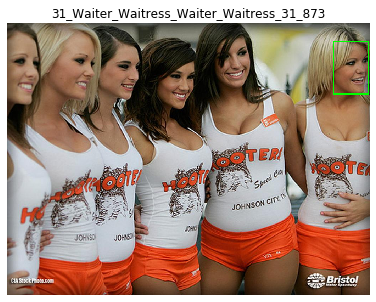

In [326]:
draw_rect(images[6], boxes[6][5:])

In [295]:
cascades_faces(haars[4], cv2.imread(path_images + '/' + images[3]))

array([[448, 121, 163, 163]], dtype=int32)

In [297]:
coords = []
for face in faces:
    coords.append(face['box'])

In [320]:
coords[:]

[[270, 67, 104, 146],
 [138, 48, 113, 160],
 [433, 105, 97, 125],
 [582, 36, 103, 142],
 [-16, 41, 109, 174],
 [365, 398, 180, 216]]

In [319]:
boxes[6]

array([[  8,  26,  88, 196],
       [128,  28, 118, 184],
       [264,  60, 110, 156],
       [420,  98, 106, 148],
       [578,  36, 106, 144],
       [920,  52, 100, 148]])

Нужно сравнивать вектора по-другому. Потому что порядок их в датасете и у нас разный.

## [dlib's HOG](http://dlib.net/)

## [dlib's MMOD](http://dlib.net/)